In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
random_state = 1015

In [2]:
root="../../.."

# To Train Model: 
## 1) define input and output file address (required input matrix: X, score, y (binary))
## 2) use the run_model function

In [3]:
import importlib.util
import os

def import_module_with_full_path(file_path):
    base_filename = os.path.basename(file_path)
    module_name = os.path.splitext(base_filename)[0]
    module_spec = importlib.util.spec_from_file_location(module_name, file_path)
    imported_module = importlib.util.module_from_spec(module_spec)
    module_spec.loader.exec_module(imported_module)
    return imported_module

from joblib import dump
run_model = import_module_with_full_path("%s/codes/AI/module/run_model.py"%(root))
run_model = run_model.run_model

model_name = "metabolome"
score_name = "score"
input_dir = "%s/codes/AI/input"%(root)
result_dir = "%s/codes/AI/output/score_random_sample/result"%(root)

data_file_path = "%s/%s.csv" %(input_dir, model_name)
metadata_file_path = "%s/metadata.csv" %(input_dir)
scores_data_file_path = "%s/%s.csv" %(input_dir, score_name)
score_y_model_file_path = "%s/codes/AI/model/%s" %(root, score_name)

result_path = "%s/metrics/%s_%s.joblib" %(result_dir, model_name, score_name)
omics_score_model_path = "%s/model/omics_score_%s_%s.h5" %(result_dir, model_name, score_name)
history_path = "%s/history/%s_%s.pkl" %(result_dir, model_name, score_name)
adjusted_score_layer_path = "%s/model/adjusted_score_layer_%s_%s.h5" %(result_dir, model_name, score_name)

#run_model(data_file_path, metadata_file_path, scores_data_file_path, score_y_model_file_path, 
#          result_path, omics_score_model_path, history_path, adjusted_score_layer_path,
#          model_name=model_name)

# Cross validation: To compare GDBT, DNN and DNN score

In [4]:
import importlib.util
import os

def import_module_with_full_path(file_path):
    base_filename = os.path.basename(file_path)
    module_name = os.path.splitext(base_filename)[0]
    module_spec = importlib.util.spec_from_file_location(module_name, file_path)
    imported_module = importlib.util.module_from_spec(module_spec)
    module_spec.loader.exec_module(imported_module)
    return imported_module

from joblib import dump
cross_validate_model = import_module_with_full_path("%s/codes/AI/module/Cross_validation.py"%(root))
cross_validate_model = cross_validate_model.cross_validate_model

model_name = "immune"
score_name = "score"
input_dir = "%s/codes/AI/input"%(root)
result_dir = "%s/codes/AI/output/cross_validation/result/metrics/"%(root)

data_file_path = "%s/%s.csv" %(input_dir, model_name)
metadata_file_path = "%s/metadata.csv" %(input_dir)
scores_data_file_path = "%s/%s.csv" %(input_dir, score_name)

result_path = "%s/%s_%s_result.joblib" %(result_dir, model_name, score_name)

#cross_validate_model(data_file_path, metadata_file_path, scores_data_file_path, result_path, model_name=None)

---
# Plots

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    y_pred = (pd.Series(y_pred) > 0.5).astype(int).tolist()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)   
    return accuracy, precision, recall, f1

In [6]:
model_name_list = ['immune','specie', 'kegg', 'metabolome', 'quest','omics']
colors = sns.color_palette("Set2", 6)
color_dict = dict(zip(model_name_list, colors))

# ROC

In [7]:
import sklearn.metrics as sk_metrics
import seaborn as sns

In [8]:
def load_roc(model_name):
    score_name = "score"
    input_dir = "%s/codes/AI/input"%(root)
    result_dir = "%s/codes/AI/output/cross_validation/result/metrics"%(root)

    result_path = "%s/%s_%s_result.joblib" %(result_dir, model_name, score_name)
    result = load(result_path)
    train_history = result['result_metrics']
    macro_acc = train_history.groupby(train_history.index // 5).mean()
    index_now = macro_acc.test_acc.idxmax()
    y_pred_table = result['y_pred_table_list'][index_now]
    y_true = y_pred_table.loc[:,'y_true'].tolist()
    y_prob = y_pred_table.loc[:,'DNN_Score_y_pred'].tolist()

    return y_true, y_prob

In [9]:
def roc_curve_plot(y_true_list, y_prob_list, title):
    model_name_list = ['immune','specie', 'kegg', 'metabolome', 'quest','omics']
    model_plot_name_list = ['Immune','Species', 'KEGG', 'Metabolome', 'Quest','Omics']
    model_plot_name_dict = dict(zip(model_name_list, model_plot_name_list))
    colors = sns.color_palette("Set2", 6)
    color_dict = dict(zip(model_name_list, colors))

    assert(y_true_list.keys() == y_prob_list.keys())
    name_list = list(y_true_list.keys())
    sns.set(style='ticks', font_scale=0.95, font='sans-serif')
    fig = plt.figure(figsize=(4.5,4), constrained_layout=True)
    
    for i in name_list:
        y_true_i, y_prob_i = y_true_list[i], y_prob_list[i]
        fpr, tpr, _ = sk_metrics.roc_curve(y_true_i, y_prob_i)
        roc_auc = sk_metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color_dict[i], lw=4, label="%s(%.2f)" %(model_plot_name_dict[i], roc_auc))
    plt.plot([0.01,1], [0.01,1], "--", lw=2, color='grey')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05,1.1])
    plt.xlabel("False Positive Rate", fontsize=20)
    plt.ylabel("True Positive Rate", fontsize=20)
    plt.legend(loc="lower right")
    plt.title(title,fontsize=15)
    
    return plt

In [10]:
model_name_list = ['omics','immune','specie', 'kegg', 'metabolome', 'quest']
y_true_list = {item: load_roc(item)[0] for item in model_name_list}
y_prob_list = {item: load_roc(item)[1] for item in model_name_list}

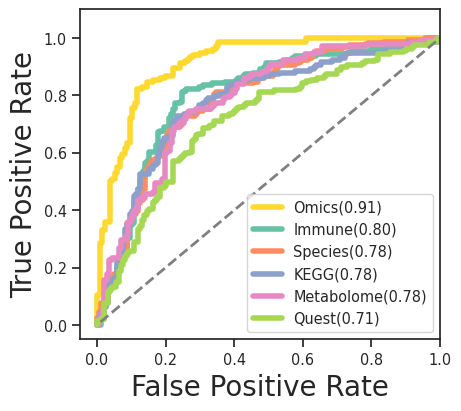

In [11]:
plt = roc_curve_plot(y_true_list, y_prob_list, "")
#plt.savefig("%s/output/AI_figure/Omics_ROC.pdf"%(root), dpi=1000, bbox_inches='tight', transparent=True)

---
# Write down the results metrics

In [12]:
def load_metrics(model_name):
    score_name = "score"
    input_dir = "%s/codes/AI/input"%(root)
    result_dir = "%s/codes/AI/output/cross_validation/result/metrics"%(root)
    model_dir = "%s/codes/AI/output/cross_validation/full_model/input"%(root)

    result_path = "%s/%s_%s_result.joblib" %(result_dir, model_name, score_name)
    result = load(result_path)

    train_history = result['result_metrics']
    macro_acc = train_history.groupby(train_history.index // 5).mean()
    index_now = macro_acc.test_acc.idxmax()
    if model_name in ['kegg', 'specie', 'metabolome']: index_now = macro_acc.test_acc.nlargest(2).index[1]
    y_pred_table = result['y_pred_table_list'][index_now]
    
    y_true = y_pred_table.loc[:,'y_true'].tolist()
    classifier = [i.replace("_y_pred","") for i in y_pred_table.columns[1:]]
    metrics_table = pd.DataFrame(index=classifier, columns=['accuracy', 'precision', 'recall', 'f1-score'])
    for i in metrics_table.index:
        y_pred = y_pred_table.loc[:,"%s_y_pred"%(i)].tolist()
        metrics_table.loc[i,:] = calculate_metrics(y_true, y_pred)
    metrics_table.index = ['%s | %s'%(model_name, i) for i in metrics_table.index]
  
    return metrics_table

In [13]:
model_name_list = ['omics','immune','kegg', 'specie', 'metabolome', 'quest']
metrics_list = [load_metrics(i) for i in model_name_list]

In [14]:
#pd.concat(metrics_list).to_csv("%s/output/AI_figure/Omics_model_compare_metrics.csv"%(root))

---
# Plot prediction for each score

In [15]:
def load_pred_score(model_name):
    score_name = "score"
    input_dir = "%s/codes/AI/input"%(root)
    result_dir = "%s/codes/AI/output/cross_validation/result/metrics"%(root)
    model_dir = "%s/codes/AI/output/cross_validation/full_model/input"%(root)
    scores_data = pd.read_csv("%s/codes/AI/input/score.csv"%(root), index_col=0)
    
    result_path = "%s/%s_%s_result.joblib" %(result_dir, model_name, score_name)
    result = load(result_path)

    scores_pred = pd.DataFrame(None, index=scores_data.index, columns=scores_data.columns)
    for sample_i in scores_pred.index:
        pred_list = {score_i: [] for score_i in scores_data.columns}
        for pred_i in result['score_pred_table_list']:
            if sample_i in pred_i.index:
                for score_i in scores_data.columns:
                    pred_list[score_i].append(pred_i.loc[sample_i,score_i])
                pred_list_medians = {key: np.median(value) for key, value in pred_list.items() if value}
                scores_pred.loc[sample_i,:]=list(pred_list_medians.values())
    scores_pred = scores_pred.dropna(how='all', axis=0)
    
    return(scores_pred)

In [16]:
model_name_list = ['omics','immune', 'specie', 'kegg', 'metabolome', 'quest']
model_plot_name_dict = dict(zip(model_name_list, ['Omics','Immune','Species', 'KEGG', 'Metabolome', 'Quest']))
pred_list = {model_i: load_pred_score(model_i) for model_i in model_name_list}

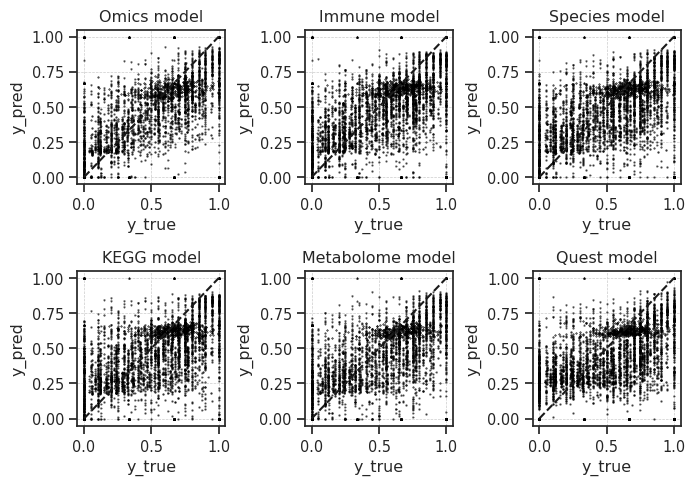

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(7, 5))
axs = axs.flatten()

for idx, model_i in enumerate(model_name_list):
    ax = axs[idx]
    data = pred_list[model_i].copy()
    scores_data = pd.read_csv("%s/codes/AI/input/score.csv"%(root), 
                              index_col=0).loc[data.index,:]
    scores_data.iloc[:,1] = scores_data.iloc[:,1]/4
    scores_data.iloc[:,2] = scores_data.iloc[:,2]/3
    data.iloc[:,2] = data.iloc[:,2]/3
    data.iloc[:,1] = data.iloc[:,1]/4
    
    y_true = scores_data.to_numpy().T
    y_pred = data.to_numpy().T
    
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', '+', 'x', 'D', '|']
    for i in range(12):
        ax.scatter(y_true[i], y_pred[i], c='black', marker=markers[i], s=0.5, alpha=0.6)
        
    ax.plot([0, 1], [0, 1], 'k--')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel('y_true')
    ax.set_ylabel('y_pred')
    ax.set_title(f'{model_plot_name_dict[model_i]} model')

plt.tight_layout()
#plt.savefig("%s/output/AI_figure/Scores_y_pred_vs_y_true_by_6_omics.png"%(root), dpi=1000, bbox_inches='tight')

## Save pred scores for density plot in R

In [18]:
scores_data = pd.read_csv("%s/codes/AI/input/score.csv"%(root), index_col=0)
pred_list['true']=scores_data
pred_list_rename = {key: df.rename(columns=lambda x: f"{key}|{x}") for key, df in pred_list.items()}
pred_list_rename = pd.concat(list(pred_list_rename.values()), axis=1, join='outer')
#pred_list_rename.to_csv("%s/codes/AI/output/cross_validation/score_pred.csv"%(root))

---
# Plot Radar

In [19]:
def load_mse(model_name):
    score_name = "score"
    input_dir = "%s/codes/AI/input"%(root)
    result_dir = "%s/codes/AI/output/cross_validation/result/metrics"%(root)

    result_path = "%s/%s_%s_result.joblib" %(result_dir, model_name, score_name)
    result = load(result_path)

    train_history = result['result_metrics']
    macro_acc = train_history.groupby(train_history.index // 5).mean()
    mse_list = pd.DataFrame(result['mse_list'])
    mse_list = mse_list.groupby(mse_list.index // 5).mean()
    index_now = macro_acc.test_acc.nlargest(2).index[1]

    mse_list = mse_list.iloc[index_now,:]
  
    return mse_list

In [20]:
model_name_list = ['immune','specie', 'kegg', 'metabolome', 'quest']
mse_omics_list = {item: load_mse(item) for item in model_name_list}

In [21]:
scores_data = pd.read_csv("%s/codes/AI/input/score.csv"%(root), index_col=0)
score_name = scores_data.columns.tolist()
score_name[1] = 'RAND36.Physical Limitations'
score_name[2] = 'RAND36.Emotional Limitations'
score_name[10] = 'PSQI.Sleeping Problem'
score_name[11] = 'GSRS.Gastrointestinal Problem'

In [22]:
mse_table = pd.DataFrame(np.array(list(mse_omics_list.values())).T, 
                         columns=mse_omics_list.keys(), 
                         index = [i.split(".")[1] for i in score_name])
mse_table.iloc[1,:] = mse_table.iloc[1,:] / 4
mse_table.iloc[2,:] = mse_table.iloc[2,:] / 3
#mse_table.to_csv("%s/output/AI_figure/Scores_Omics_MSE.csv"%(root))
mse_table = 1 - mse_table

## cluster mse table

In [23]:
from scipy.cluster.hierarchy import linkage, fcluster
linked = linkage(mse_table, method='ward')
labels = fcluster(linked, 4, criterion='maxclust')
mse_table['Cluster'] = labels
ranked_df = mse_table.sort_values(by='Cluster')
mse_table = ranked_df.drop('Cluster', axis=1)

In [24]:
def normalize_row(row):
    max_value = row.max()
    min_value = row.min()
    normalized_row = (row - min_value) * (1 - min_value) / (max_value - min_value) + min_value
    return normalized_row


# Apply the normalization function to each row in the DataFrame
normalized_mse_table = mse_table.apply(normalize_row, axis=1)
normalized_mse_table = normalized_mse_table.loc[mse_table.index,:]

In [25]:
model_order = ['immune', 'specie', 'kegg', 'metabolome', 'quest'][::-1]
score_order = ['Social Functioning', 
               'Sleeping Problem', 'Gastrointestinal Problem','Emotional wellbeing', 'Orthostatic Intolerance',
               'Emotional Limitations','Physical Functioning', 'General Health','Physical Limitations',
               'Energy/Fatigue', 'Pain', 'Cognitive Efficiency']
normalized_mse_table = normalized_mse_table.loc[score_order,model_order]
normalized_mse_table.columns = ['Quest','Metabolome','KEGG','Species','Immune']
normalized_mse_table.index = [i.replace(' ','\n') for i in normalized_mse_table.index]

In [26]:
def radar_plot(table):
    model_name_list = ['Immune','Species', 'KEGG', 'Metabolome', 'Quest','Omics']
    colors = sns.color_palette("Set2", 6)
    color_dict = dict(zip(model_name_list, colors))

    attributes = table.index
    num_attributes = len(attributes)

    angles = np.linspace(0, 2*np.pi, num_attributes, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    sns.set(style='ticks', font_scale=0.6, font='sans-serif')
    fig = plt.figure(figsize=(4,4))

    for entity in table.columns[::-1]:
        entity_data = table.loc[:, entity]
        entity_data = np.concatenate((entity_data, [entity_data[0]]))
        plt.polar(angles, entity_data, marker='o', color=color_dict[entity], label=entity)
        plt.fill(angles, entity_data, color=color_dict[entity], alpha=0.08)

    plt.xticks(angles[:-1], attributes, fontsize=10)

    plt.ylim(table.min().min() - 0.05, table.max().max() + 0.01)
    plt.yticks(alpha=0)
    plt.legend(loc='lower right', bbox_to_anchor=(1.15, -0.11))
    return plt

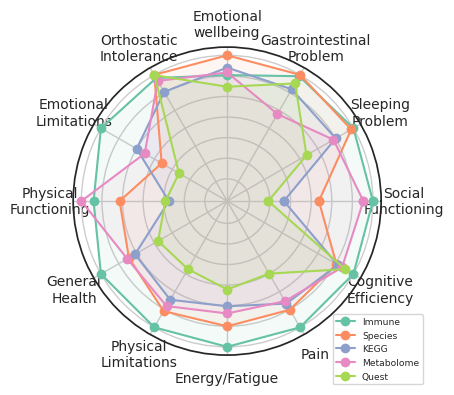

In [27]:
plt = radar_plot(normalized_mse_table)
#plt.savefig("%s/output/AI_figure/Scores_Radar.pdf"%(root), dpi=1000, bbox_inches='tight', transparent=True)